# Convergence of (linear/non-linear) one-dimensional convnets with normalization

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


In [2]:
def pad_circular1d(x, pad):
    x = torch.cat([x, x[0:pad]])
    x = torch.cat([x[-2 * pad:-pad], x])
    return x

class Pad1d(torch.nn.Module):
    def __init__(self, pad):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Pad1d, self).__init__()
        self.pad = pad
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        shape = [1,x.shape[1],x.shape[2]+2*self.pad]
        xx = Variable(torch.zeros(shape)).type(dtype)
        for i in range(x.shape[1]):
            xx[0,i] = pad_circular1d(x[0,i],self.pad)
        return xx # pad_circular1d(x, self.pad)

y = Variable( torch.tensor([1,2,3,4]) ).type(dtype)
yy = Variable( torch.tensor([[[1,2,3,4]]]) ).type(dtype)

pad = 1
shape = [1,2,yy.shape[2]+2*pad]
py = Variable(torch.zeros(shape)).type(dtype)
py[0,0] = pad_circular1d(yy[0,0],pad)
print(py)

tensor([[[4., 1., 2., 3., 4., 1.],
         [0., 0., 0., 0., 0., 0.]]], device='cuda:0')


In [3]:
def print_filters(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            print(m.weight.data.cpu().numpy())  

def plot_gradients(out_grads):
    for i,g in enumerate(out_grads):
        plt.semilogy(g,label=str(i)) 
    plt.legend()
    plt.show()

# test conv
n = 4
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4]]])) ).type(dtype)
print(y)

cl = conv(1, 1, 3, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 2

#cl.apply( initialize )
#print_filters(cl)
#print("y:", y)

#out = cl(y)
#print(out)
# works correctly..

tensor([[[1., 2., 3., 4.]]], device='cuda:0')


In [4]:
def conv(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    '''
    Circular convolution
    '''
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)


# test conv
n = 8
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4,5,6,7,8]]])) ).type(dtype)
print(y)

print(cl)
cl = conv(1, 1, 5, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 1
                m.weight.data[0,0,3] = 0
                m.weight.data[0,0,4] = 0

cl.apply( initialize )
print_filters(cl)
print("y:", y)

out = cl(y)
print("result: ", out)
# works correctly..

tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
[[[0. 1. 1. 0. 0.]]]
y: tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
result:  tensor([[[ 9.,  3.,  5.,  7.,  9., 11., 13., 15.]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [5]:
class ChannelNormalization(torch.nn.Module):
    '''
    Different ways to normalize the channels
    '''
    def __init__(self, D_in,mode="BN"):
        self.mode = mode
        super(ChannelNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))
        
    def forward(self, x):
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g  + b
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) )
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            elif self.mode == "linear":
                xx = x
            else:
                raise ValueError('not an option for channel normalization.')
        return xx

In [6]:
def conv2(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
        padder = nn.ReflectionPad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)

class ResidualBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size, stride=1,bias=False,pad=True,mode="BN"):
        super(ResidualBlock, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride=stride,bias=bias,pad=pad)
        self.norm = ChannelNormalization(in_f,mode=mode)
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.norm(out)
        out += residual
        return out

def decnet(
        num_output_channels=1, 
        num_channels_up=[1]*5, 
        filter_size_up=2,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "BN",
        modeout = "none",
        res = True,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    for i in range(len(num_channels_up)-1):
        if res:
            model.add(ResidualBlock( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1,mode))
        else:

            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1))
            if act_fun != None:
                model.add(act_fun)
            model.add(ChannelNormalization(num_channels_up[i],mode=mode))
            #model.add( nn.BatchNorm1d( num_channels_up[i] ,affine=True) )

            
    if modeout != "none":
        model.add(ChannelNormalization(num_channels_up[i+1],mode=modeout))
        #model.add( nn.BatchNorm1d( num_channels_up[i+1] ,affine=True) )
    model.add(conv( num_channels_up[-1], num_output_channels, 1,bias=True,pad=False))
    model.add(nn.Sigmoid())
    
    return model

## test conv
y = Variable( torch.tensor([1,2,3,4]) ).type(dtype)
yy = Variable( torch.tensor([[[1,2,3,4]]]) ).type(dtype)

#shape = [1,1,yy.shape[2]]
#py = Variable(torch.zeros(shape)).type(dtype)
#py[0,0] = yy
#c = conv(1,1,3)
#print(c.convolver.weights.data)
#print( c(py) )

In [7]:
def fit(net,
        y,
        num_channels,
        net_input = None,
        num_iter = 5000,
        LR = 0.01,
       ):

    if net_input is not None:
        print("input provided")
    else:
        length = int(y.data.shape[2])
        shape = [1,num_channels[0], length ]
        print("input shape: ", shape)
        net_input = Variable(torch.zeros(shape)).type(dtype)
        net_input.data.uniform_()
    
    net_input = net_input.type(dtype)
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
     
    print("optimize with SGD", LR)
    optimizer = torch.optim.SGD(p, lr=LR,momentum=0.9)
    
    mse = torch.nn.MSELoss() #.type(dtype) 
   
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros((nconvnets,num_iter))
    out_filters = np.zeros((nconvnets+1,num_iter))
        
    for i in range(num_iter):
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))

            # training loss 
            loss = mse(out, y)
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
            
            # output gradients
            for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
                out_grads[ind,i] = p.grad.data.norm(2).item()
            
            # output norms of filters
            ind = 0
            for m in net.modules():
                if isinstance(m, nn.Conv1d):
                    out_filters[ind,i] = m.weight.data.norm(2).item()
                    ind += 1
                    #print(m.weight.data.cpu().numpy())  
                   
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f' % (i, loss.data), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
                  
    return mse_wrt_noisy, net_input, net, out_grads, out_filters

## generate signals

In [8]:
n = 1024

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep = np_to_var(ystep_np).type(dtype)
ystep_np = ystep_np[0]
print(ystep.shape)

torch.Size([1, 1, 1024])


# ReLU networks

## standard BN

input shape:  [1, 4, 1024]
optimize with SGD 0.1


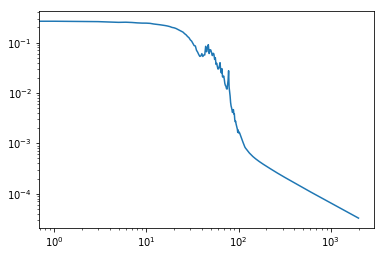

Error: 1.0053456


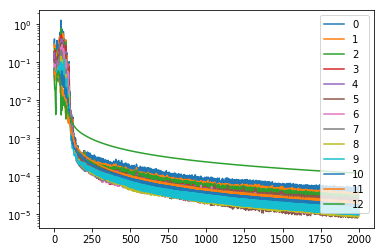

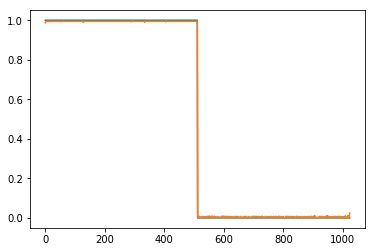

In [9]:
num_channels = [4]*12
net = decnet(1,num_channels,3,act_fun=nn.ReLU(),mode="BN",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,ystep,num_channels,num_iter = 2000,LR = 0.1)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

## non-learned

input shape:  [1, 4, 1024]
optimize with SGD 0.1


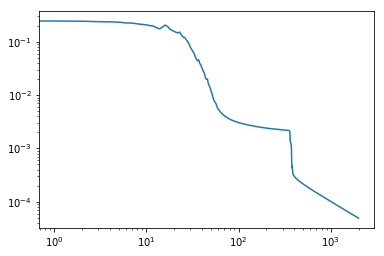

Error: 1.0037361


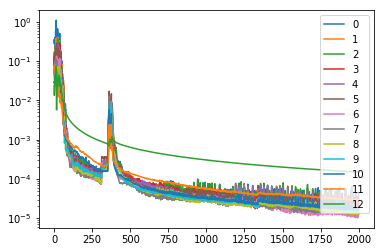

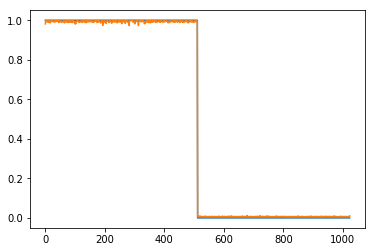

In [10]:
num_channels = [4]*12
net = decnet(1,num_channels,3,act_fun=nn.ReLU(),mode="non-learned",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,ystep,num_channels,num_iter = 2000,LR = 0.1)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

## only+bias, so that the expressive power is exactly the same

input shape:  [1, 4, 1024]
optimize with SGD 0.1


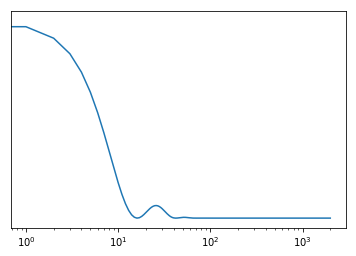

Error: 0.5062624


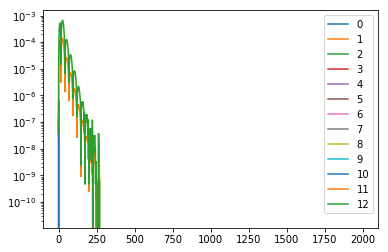

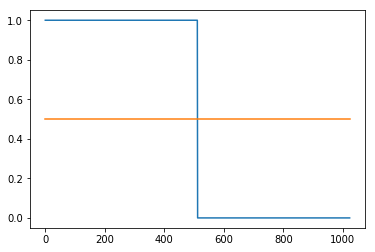

In [11]:
num_channels = [4]*12
net = decnet(1,num_channels,3,act_fun=nn.ReLU(),mode="only+bias",res=False).type(dtype) # can also be "linear"

mse, ni, net, out_grads, out_norms = fit(net,ystep,num_channels,num_iter = 2000,LR = 0.1)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

# Linear networks

In [12]:
n = 64

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep = np_to_var(ystep_np).type(dtype)
ystep_np = ystep_np[0]
print(ystep.shape)

torch.Size([1, 1, 64])


## With batch normalization

input shape:  [1, 1, 64]
optimize with SGD 0.1


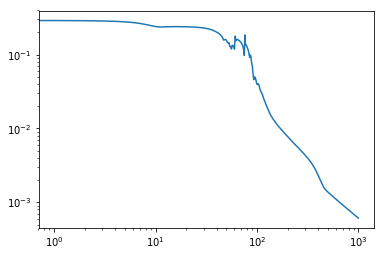

Error: 1.0544238


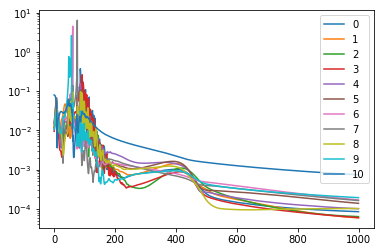

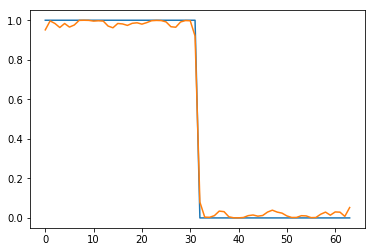

In [13]:
num_channels = [1]*10
net = decnet(1,num_channels,9,act_fun=None,mode="BN",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,ystep,num_channels,num_iter = 1000,LR = 0.1)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

## without batch normalization

input shape:  [1, 1, 64]
optimize with SGD 0.1


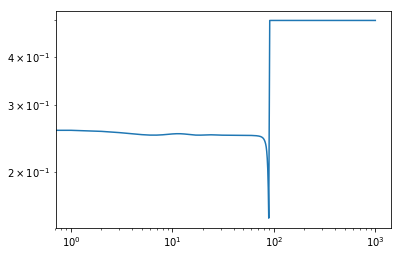

Error: 0.95000005


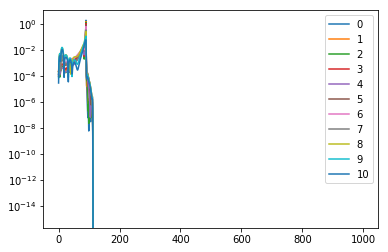

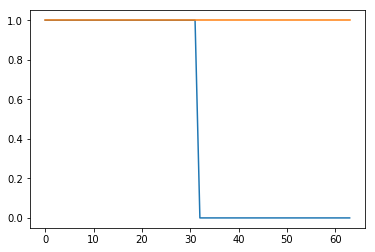

In [14]:
num_channels = [1]*10
net = decnet(1,num_channels,9,act_fun=None,mode="only+bias",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,ystep,num_channels,num_iter = 1000,LR = 0.1)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

In [ ]:
def res_to_mtx(results,filename):
    ks = [i for i in range(len( results[0] ))]
    A = [np.array(ks)]
    for res in results:
        A += [np.array(res)]
    A = np.vstack( A ).T
    print(A)
    savemtx_for_logplot(A.T,filename)
    

def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=700)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')